In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# The next line is to make the plots appear in the notebook
%matplotlib inline 

In this project the database will be downloaded from the PVGis 5.2 database using SARAH2 Satellite. The image below shows the coverage of it.
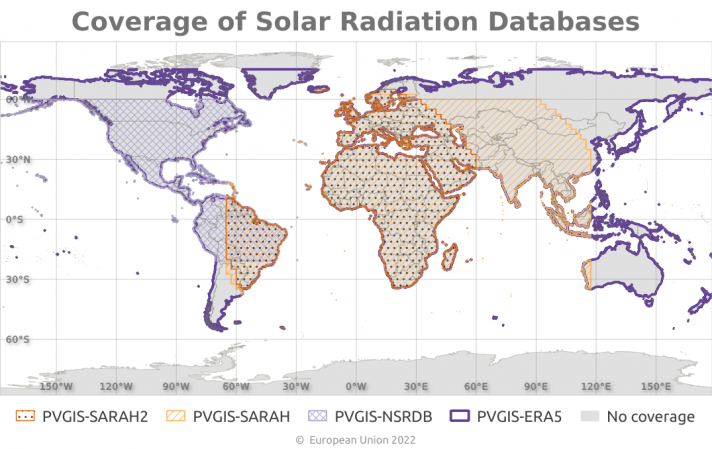
Coverage of Solar Radiation Databases in PVGIS 5.2
European Union, 2022

In [2]:
import io
import json
from pathlib import Path
import requests
import pandas as pd
from pvlib.iotools import read_epw, parse_epw
import warnings
from pvlib._deprecation import pvlibDeprecationWarning

URL = 'https://re.jrc.ec.europa.eu/api/v5_2/'

# Dictionary mapping PVGIS names to pvlib names
VARIABLE_MAP = {
    'G(h)': 'ghi',
    'Gb(n)': 'dni',
    'Gd(h)': 'dhi',
    'G(i)': 'poa_global',
    'Gb(i)': 'poa_direct',
    'Gd(i)': 'poa_sky_diffuse',
    'Gr(i)': 'poa_ground_diffuse',
    'H_sun': 'solar_elevation',
    'T2m': 'temp_air',
    'RH': 'relative_humidity',
    'SP': 'pressure',
    'WS10m': 'wind_speed',
    'WD10m': 'wind_direction',
}


def get_pvgis_hourly(latitude, longitude, start=None, end=None,
                     raddatabase=None, components=True,
                     surface_tilt=0, surface_azimuth=0,
                     outputformat='json',
                     usehorizon=True, userhorizon=None,
                     pvcalculation=False,
                     peakpower=None, pvtechchoice='crystSi',
                     mountingplace='free', loss=0, trackingtype=0,
                     optimal_surface_tilt=False, optimalangles=False,
                     url=URL, map_variables=True, timeout=30):
    
    
    # noqa: E501
    # use requests to format the query string by passing params dictionary
    params = {'lat': latitude, 'lon': longitude, 'outputformat': outputformat,
              'angle': surface_tilt, 'aspect': surface_azimuth,
              'pvcalculation': int(pvcalculation),
              'pvtechchoice': pvtechchoice, 'mountingplace': mountingplace,
              'trackingtype': trackingtype, 'components': int(components),
              'usehorizon': int(usehorizon),
              'optimalangles': int(optimalangles),
              'optimalinclination': int(optimal_surface_tilt), 'loss': loss}
    # pvgis only takes 0 for False, and 1 for True, not strings
    if userhorizon is not None:
        params['userhorizon'] = ','.join(str(x) for x in userhorizon)
    if raddatabase is not None:
        params['raddatabase'] = raddatabase
    if start is not None:
        params['startyear'] = start if isinstance(start, int) else start.year
    if end is not None:
        params['endyear'] = end if isinstance(end, int) else end.year
    if peakpower is not None:
        params['peakpower'] = peakpower

    # The url endpoint for hourly radiation is 'seriescalc'
    res = requests.get(url + 'seriescalc', params=params, timeout=timeout)
    # PVGIS returns really well formatted error messages in JSON for HTTP/1.1
    # 400 BAD REQUEST so try to return that if possible, otherwise raise the
    # HTTP/1.1 error caught by requests
    if not res.ok:
        try:
            err_msg = res.json()
        except Exception:
            res.raise_for_status()
        else:
            raise requests.HTTPError(err_msg['message'])

    return read_pvgis_hourly(io.StringIO(res.text), pvgis_format=outputformat,
                             map_variables=map_variables)



def _parse_pvgis_hourly_json(src, map_variables):
    inputs = src['inputs']
    metadata = src['meta']
    data = pd.DataFrame(src['outputs']['hourly'])
    data.index = pd.to_datetime(data['time'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time', axis=1)
    data = data.astype(dtype={'Int': 'int'})  # The 'Int' column to be integer
    if map_variables:
        data = data.rename(columns=VARIABLE_MAP)
    return data, inputs, metadata


def _parse_pvgis_hourly_csv(src, map_variables):
    # The first 4 rows are latitude, longitude, elevation, radiation database
    inputs = {}
    # 'Latitude (decimal degrees): 45.000\r\n'
    inputs['latitude'] = float(src.readline().split(':')[1])
    # 'Longitude (decimal degrees): 8.000\r\n'
    inputs['longitude'] = float(src.readline().split(':')[1])
    # Elevation (m): 1389.0\r\n
    inputs['elevation'] = float(src.readline().split(':')[1])
    # 'Radiation database: \tPVGIS-SARAH\r\n'
    inputs['radiation_database'] = src.readline().split(':')[1].strip()
    # Parse through the remaining metadata section (the number of lines for
    # this section depends on the requested parameters)
    while True:
        line = src.readline()
        if line.startswith('time,'):  # The data header starts with 'time,'
            # The last line of the metadata section contains the column names
            names = line.strip().split(',')
            break
        # Only retrieve metadata from non-empty lines
        elif line.strip() != '':
            inputs[line.split(':')[0]] = line.split(':')[1].strip()
        elif line == '':  # If end of file is reached
            raise ValueError('No data section was detected. File has probably '
                             'been modified since being downloaded from PVGIS')
    # Save the entries from the data section to a list, until an empty line is
    # reached an empty line. The length of the section depends on the request
    data_lines = []
    while True:
        line = src.readline()
        if line.strip() == '':
            break
        else:
            data_lines.append(line.strip().split(','))
    data = pd.DataFrame(data_lines, columns=names)
    data.index = pd.to_datetime(data['time'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time', axis=1)
    if map_variables:
        data = data.rename(columns=VARIABLE_MAP)
    # All columns should have the dtype=float, except 'Int' which should be
    # integer. It is necessary to convert to float, before converting to int
    data = data.astype(float).astype(dtype={'Int': 'int'})
    # Generate metadata dictionary containing description of parameters
    metadata = {}
    for line in src.readlines():
        if ':' in line:
            metadata[line.split(':')[0]] = line.split(':')[1].strip()
    return data, inputs, metadata


def read_pvgis_hourly(filename, pvgis_format=None, map_variables=True):
   
    # get the PVGIS outputformat
    if pvgis_format is None:
        # get the file extension from suffix, but remove the dot and make sure
        # it's lower case to compare with csv, or json
        # NOTE: basic format is not supported for PVGIS Hourly as the data
        # format does not include a header
        # NOTE: raises TypeError if filename is a buffer
        outputformat = Path(filename).suffix[1:].lower()
    else:
        outputformat = pvgis_format

    # parse the pvgis file based on the output format, either 'json' or 'csv'
    # NOTE: json and csv output formats have parsers defined as private
    # functions in this module

    # JSON: use Python built-in json module to convert file contents to a
    # Python dictionary, and pass the dictionary to the
    # _parse_pvgis_hourly_json() function from this module
    if outputformat == 'json':
        try:
            src = json.load(filename)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'r') as fbuf:
                src = json.load(fbuf)
        return _parse_pvgis_hourly_json(src, map_variables=map_variables)

    # CSV: use _parse_pvgis_hourly_csv()
    if outputformat == 'csv':
        try:
            pvgis_data = _parse_pvgis_hourly_csv(
                filename, map_variables=map_variables)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'r') as fbuf:
                pvgis_data = _parse_pvgis_hourly_csv(
                    fbuf, map_variables=map_variables)
        return pvgis_data

    # raise exception if pvgis format isn't in ['csv', 'json']
    err_msg = (
        "pvgis format '{:s}' was unknown, must be either 'json' or 'csv'")\
        .format(outputformat)
    raise ValueError(err_msg)

In [3]:
#Defining the inputs
lat = 52.5 
lon = 13.4
start=pd.Timestamp('2005-01-01')
end=pd.Timestamp('2020-12-31')
raddatabase='PVGIS-SARAH2'
loss=30

data = get_pvgis_hourly(latitude = lat, 
                    longitude = lon, 
                    start=start, 
                    end=end,
                    raddatabase=raddatabase,
                    components=True, #Maybe need to change for 1
                    surface_tilt = lat, #consideriran Latitude as the Optimal angle 
                    surface_azimuth=0, # 0=south For Noth Hemisphere
                    outputformat='csv',
                    usehorizon=True, #Include effects of horizon
                    userhorizon=None, #Optional user specified elevation of horizon in degrees - Will not use it 
                    pvcalculation=True,
                    peakpower= 30, # Source: https://www.berlin.de/umweltatlas/en/energy/solar-systems/continually-updated/map-description/ 
                    pvtechchoice='crystSi',
                    mountingplace='free',  #Type of mounting for PV system. Options of 'free' for free-standing 
                                           #and 'building' for building-integrated.
                    loss= loss, #considering a global loss of 30% section 11.2.2 Source: https://www.ise.fraunhofer.de/content/dam/ise/en/documents/publications/studies/recent-facts-about-photovoltaics-in-germany.pdf 
                    trackingtype=0, #Type of mounting 0=fixed
                    optimal_surface_tilt=True, #Calculate the optimum tilt angle.
                    optimalangles=False, #Calculate the optimum tilt and azimuth angles.                      
                    url=URL, 
                    map_variables=True, # When true, renames columns of the Dataframe to pvlib variable names
                    timeout=30) # Time in seconds to wait for server response before timeout

In [4]:
pv_data = data[0]
pv_data.head()

,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int
time,,,,,,,,
2005-01-01 00:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.83,3.59,0
2005-01-01 01:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.76,3.45,0
2005-01-01 02:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.77,3.31,0
2005-01-01 03:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.29,2.90,0
2005-01-01 04:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.21,2.69,0


In [13]:
pv_data.sort_values(by="time")

,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int
time,,,,,,,,
2005-01-01 00:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.83,3.59,0
2005-01-01 01:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.76,3.45,0
2005-01-01 02:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.77,3.31,0
2005-01-01 03:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.29,2.90,0
2005-01-01 04:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.21,2.69,0
...,...,...,...,...,...,...,...,...
2020-12-31 19:11:00+00:00,0.0,0.0,0.0,0.0,0.0,1.41,2.41,0
2020-12-31 20:11:00+00:00,0.0,0.0,0.0,0.0,0.0,1.52,2.62,0
2020-12-31 21:11:00+00:00,0.0,0.0,0.0,0.0,0.0,1.68,2.62,0


In [6]:
def get_pvgis_tmy(latitude, longitude, outputformat='json', usehorizon=True,
                  userhorizon=None, startyear=None, endyear=None, url=URL,
                  map_variables=None, timeout=30):

    # use requests to format the query string by passing params dictionary
    params = {'lat': latitude, 'lon': longitude, 'outputformat': outputformat}
    # pvgis only likes 0 for False, and 1 for True, not strings, also the
    # default for usehorizon is already 1 (ie: True), so only set if False
    if not usehorizon:
        params['usehorizon'] = 0
    if userhorizon is not None:
        params['userhorizon'] = ','.join(str(x) for x in userhorizon)
    if startyear is not None:
        params['startyear'] = startyear
    if endyear is not None:
        params['endyear'] = endyear
    res = requests.get(url + 'tmy', params=params, timeout=timeout)
    # PVGIS returns really well formatted error messages in JSON for HTTP/1.1
    # 400 BAD REQUEST so try to return that if possible, otherwise raise the
    # HTTP/1.1 error caught by requests
    if not res.ok:
        try:
            err_msg = res.json()
        except Exception:
            res.raise_for_status()
        else:
            raise requests.HTTPError(err_msg['message'])
    # initialize data to None in case API fails to respond to bad outputformat
    data = None, None, None, None
    if outputformat == 'json':
        src = res.json()
        data, months_selected, inputs, meta = _parse_pvgis_tmy_json(src)
    elif outputformat == 'csv':
        with io.BytesIO(res.content) as src:
            data, months_selected, inputs, meta = _parse_pvgis_tmy_csv(src)
    elif outputformat == 'basic':
        with io.BytesIO(res.content) as src:
            data, months_selected, inputs, meta = _parse_pvgis_tmy_basic(src)
    elif outputformat == 'epw':
        with io.StringIO(res.content.decode('utf-8')) as src:
            data, meta = parse_epw(src)
            months_selected, inputs = None, None
    else:
        # this line is never reached because if outputformat is not valid then
        # the response is HTTP/1.1 400 BAD REQUEST which is handled earlier
        pass

    if map_variables is None:
        warnings.warn(
            'PVGIS variable names will be renamed to pvlib conventions by '
            'default starting in pvlib 0.10.0. Specify map_variables=True '
            'to enable that behavior now, or specify map_variables=False '
            'to hide this warning.', pvlibDeprecationWarning
        )
        map_variables = False
    if map_variables:
        data = data.rename(columns=VARIABLE_MAP)

    return data, months_selected, inputs, meta

def _parse_pvgis_tmy_json(src):
    inputs = src['inputs']
    meta = src['meta']
    months_selected = src['outputs']['months_selected']
    data = pd.DataFrame(src['outputs']['tmy_hourly'])
    data.index = pd.to_datetime(
        data['time(UTC)'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time(UTC)', axis=1)
    return data, months_selected, inputs, meta


def _parse_pvgis_tmy_csv(src):
    # the first 3 rows are latitude, longitude, elevation
    inputs = {}
    # 'Latitude (decimal degrees): 45.000\r\n'
    inputs['latitude'] = float(src.readline().split(b':')[1])
    # 'Longitude (decimal degrees): 8.000\r\n'
    inputs['longitude'] = float(src.readline().split(b':')[1])
    # Elevation (m): 1389.0\r\n
    inputs['elevation'] = float(src.readline().split(b':')[1])
    # then there's a 13 row comma separated table with two columns: month, year
    # which contains the year used for that month in the
    src.readline()  # get "month,year\r\n"
    months_selected = []
    for month in range(12):
        months_selected.append(
            {'month': month+1, 'year': int(src.readline().split(b',')[1])})
    # then there's the TMY (typical meteorological year) data
    # first there's a header row:
    #    time(UTC),T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP
    headers = [h.decode('utf-8').strip() for h in src.readline().split(b',')]
    data = pd.DataFrame(
        [src.readline().split(b',') for _ in range(8760)], columns=headers)
    dtidx = data['time(UTC)'].apply(lambda dt: dt.decode('utf-8'))
    dtidx = pd.to_datetime(dtidx, format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time(UTC)', axis=1)
    data = pd.DataFrame(data, dtype=float)
    data.index = dtidx
    # finally there's some meta data
    meta = [line.decode('utf-8').strip() for line in src.readlines()]
    return data, months_selected, inputs, meta


def _parse_pvgis_tmy_basic(src):
    data = pd.read_csv(src)
    data.index = pd.to_datetime(
        data['time(UTC)'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time(UTC)', axis=1)
    return data, None, None, None


def read_pvgis_tmy(filename, pvgis_format=None, map_variables=None):
 
    # get the PVGIS outputformat
    if pvgis_format is None:
        # get the file extension from suffix, but remove the dot and make sure
        # it's lower case to compare with epw, csv, or json
        # NOTE: raises TypeError if filename is a buffer
        outputformat = Path(filename).suffix[1:].lower()
    else:
        outputformat = pvgis_format
    # parse the pvgis file based on the output format, either 'epw', 'json',
    # 'csv', or 'basic'

    # EPW: use the EPW parser from the pvlib.iotools epw.py module
    if outputformat == 'epw':
        try:
            data, meta = parse_epw(filename)
        except AttributeError:  # str/path has no .read() attribute
            data, meta = read_epw(filename)
        months_selected, inputs = None, None

    # NOTE: json, csv, and basic output formats have parsers defined as private
    # functions in this module

    # JSON: use Python built-in json module to convert file contents to a
    # Python dictionary, and pass the dictionary to the _parse_pvgis_tmy_json()
    # function from this module
    elif outputformat == 'json':
        try:
            src = json.load(filename)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'r') as fbuf:
                src = json.load(fbuf)
        data, months_selected, inputs, meta = _parse_pvgis_tmy_json(src)

    # CSV or basic: use the correct parser from this module
    # eg: _parse_pvgis_tmy_csv() or _parse_pvgist_tmy_basic()
    elif outputformat in ['csv', 'basic']:
        # get the correct parser function for this output format from globals()
        pvgis_parser = globals()['_parse_pvgis_tmy_{:s}'.format(outputformat)]
        # NOTE: pvgis_parse() is a pvgis parser function from this module,
        # either _parse_pvgis_tmy_csv() or _parse_pvgist_tmy_basic()
        try:
            data, months_selected, inputs, meta = pvgis_parser(filename)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'rb') as fbuf:
                data, months_selected, inputs, meta = pvgis_parser(fbuf)

    else:
        # raise exception if pvgis format isn't in ['csv','basic','epw','json']
        err_msg = (
            "pvgis format '{:s}' was unknown, must be either 'epw', 'json', "
            "'csv', or 'basic'").format(outputformat)
        raise ValueError(err_msg)

    if map_variables is None:
        warnings.warn(
            'PVGIS variable names will be renamed to pvlib conventions by '
            'default starting in pvlib 0.10.0. Specify map_variables=True '
            'to enable that behavior now, or specify map_variables=False '
            'to hide this warning.', pvlibDeprecationWarning
        )
        map_variables = False
    if map_variables:
        data = data.rename(columns=VARIABLE_MAP)

    return data, months_selected, inputs, meta


In [7]:
weather = get_pvgis_tmy(latitude = lat, 
                        longitude = lon, 
                        outputformat='json', 
                        usehorizon=True,
                        userhorizon=None, 
                        startyear=start.year, 
                        endyear=end.year, 
                        url=URL,
                        map_variables=True, 
                        timeout=30)

In [8]:
weatherdf = weather[0] #pressure in  mbar
weatherdf.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2018-01-01 00:00:00+00:00,6.00,82.04,0.0,0.0,0.0,313.04,4.82,211.0,99367.0
2018-01-01 01:00:00+00:00,6.76,80.58,0.0,0.0,0.0,313.89,4.95,213.0,99348.0
2018-01-01 02:00:00+00:00,7.53,79.12,0.0,0.0,0.0,314.74,5.07,220.0,99348.0
2018-01-01 03:00:00+00:00,8.29,77.65,0.0,0.0,0.0,315.59,5.19,228.0,99387.0
2018-01-01 04:00:00+00:00,9.06,76.19,0.0,0.0,0.0,316.44,5.31,232.0,99437.0


In [9]:
weatherdf.describe().round(2)

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
count,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00
mean,9.81,74.43,123.14,118.95,63.16,313.28,3.02,201.19,101059.16
std,8.37,17.25,201.10,231.93,94.04,42.17,1.37,90.97,919.44
min,-15.09,25.45,0.00,0.00,0.00,179.50,-0.03,0.00,97755.00
25%,3.76,62.54,0.00,0.00,0.00,283.25,2.07,123.00,100472.00
50%,10.09,78.35,0.00,0.00,0.00,314.62,2.83,222.00,101079.00
75%,16.37,88.95,162.00,89.61,105.00,345.35,3.79,271.00,101706.00
max,32.29,100.00,909.00,970.33,436.00,424.80,11.32,360.00,103269.00


In [10]:
weatherdf.sort_values(by="time(UTC)")

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2006-02-01 00:00:00+00:00,1.86,93.46,0.0,0.0,0.0,307.38,3.67,262.0,102015.0
2006-02-01 01:00:00+00:00,0.88,94.42,0.0,0.0,0.0,302.14,3.38,262.0,102005.0
2006-02-01 02:00:00+00:00,-0.11,95.38,0.0,0.0,0.0,296.90,3.09,262.0,102005.0
2006-02-01 03:00:00+00:00,-1.09,96.34,0.0,0.0,0.0,291.67,2.80,265.0,101955.0
2006-02-01 04:00:00+00:00,-2.07,97.30,0.0,0.0,0.0,286.43,2.52,267.0,101925.0
...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00+00:00,1.88,81.05,0.0,0.0,0.0,280.35,2.43,315.0,102184.0
2020-11-30 20:00:00+00:00,0.88,79.30,0.0,0.0,0.0,277.59,2.74,315.0,102194.0
2020-11-30 21:00:00+00:00,-0.12,77.54,0.0,0.0,0.0,274.83,3.05,312.0,102194.0


In [14]:
pv_data.sort_values(by="time")

,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int
time,,,,,,,,
2005-01-01 00:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.83,3.59,0
2005-01-01 01:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.76,3.45,0
2005-01-01 02:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.77,3.31,0
2005-01-01 03:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.29,2.90,0
2005-01-01 04:11:00+00:00,0.0,0.0,0.0,0.0,0.0,6.21,2.69,0
...,...,...,...,...,...,...,...,...
2020-12-31 19:11:00+00:00,0.0,0.0,0.0,0.0,0.0,1.41,2.41,0
2020-12-31 20:11:00+00:00,0.0,0.0,0.0,0.0,0.0,1.52,2.62,0
2020-12-31 21:11:00+00:00,0.0,0.0,0.0,0.0,0.0,1.68,2.62,0


In [16]:
weatherdf.to_csv(r'.\weatherdf.csv')

In [17]:
pv_data.to_csv(r'.\pv_data.csv')

In [21]:
conda config --add channels conda-forge
conda config --set channel_priority strict
conda install pvlib pvlib-python

SyntaxError: invalid syntax (3952024972.py, line 1)

In [20]:

import pvlib

SyntaxError: invalid syntax (2893106729.py, line 1)

In [ ]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude,
                                          map_variables=True)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)
    
system = {'module': module, 'inverter': inverter,
          'surface_azimuth': 180}


energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )
    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)
energies.head()